In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2021-07-21 09:48:22.149868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 09:48:22.149886: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("dataset.csv",sep=';',low_memory=False)
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy().drop(['NOxHjortnes','NOxBygdoyAlle', 'NOxE6Alna', 'NOxKirkeveien','NOxManglerud', 'NOxSmestad'],axis=1)
test_features = test_dataset.copy().drop(['NOxHjortnes','NOxBygdoyAlle', 'NOxE6Alna', 'NOxKirkeveien','NOxManglerud', 'NOxSmestad'],axis=1)

train_labels = train_dataset.copy()[['NOxHjortnes','NOxBygdoyAlle', 'NOxE6Alna', 'NOxKirkeveien','NOxManglerud', 'NOxSmestad']]
test_labels = test_dataset.copy()[['NOxHjortnes','NOxBygdoyAlle', 'NOxE6Alna', 'NOxKirkeveien','NOxManglerud', 'NOxSmestad']]


normalizer = preprocessing.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())
    

2021-07-21 09:48:54.729202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-21 09:48:54.729222: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-21 09:48:54.729237: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thnkpad): /proc/driver/nvidia/version does not exist
2021-07-21 09:48:54.729389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-21 09:48:54.757059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimi

[1.1621339e+01 2.3315318e+00 5.9985147e+00 3.0241184e+00 1.6731421e+02
 1.8181838e-01 2.8124592e+00 7.0457778e+00 7.2590599e+01 1.3235770e+02
 5.4214549e+00 9.9778533e-02]
First example: [[  0.     3.     7.     5.   201.     0.     1.6   16.3   95.   181.
    7.3    0.05]]

Normalized: [[-1.67  0.62  0.29  0.97  0.31 -0.47 -0.71  1.16  1.08  0.47  0.82 -0.25]]


In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.001)
    )
    return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 12)                25        
_________________________________________________________________
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,082
Trainable params: 5,057
Non-trainable params: 25
_________________________________________________________________


In [4]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


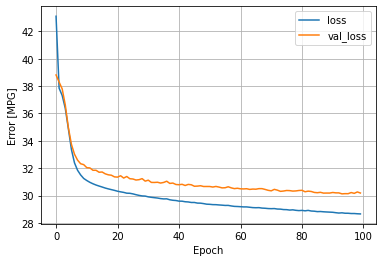

In [5]:
plot_loss(history)

In [6]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels['NOxHjortnes'], verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T
test_predictions = dnn_model.predict(test_features).flatten()